In [18]:
# %pip install sklearn
import folium
import json
from requests import get
import pickle
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns


In [3]:
# Get LAT LONG
VLC_LATITUDE = '39.4699418'
VLC_LONGITUDE = '-0.3763858'
print('The geograpical coordinates of Valencia are {}, {}.'.format(VLC_LATITUDE, VLC_LONGITUDE))

The geograpical coordinates of Valencia are 39.4699418, -0.3763858.


In [4]:
# PRINT MAP
vlc_map = folium.Map(location = [VLC_LATITUDE, VLC_LONGITUDE], zoom_start = 12)
folium.Marker([VLC_LATITUDE, VLC_LONGITUDE]).add_to(vlc_map)
folium.GeoJson('opendata1834388748628975202.geojson', name='lol').add_to(vlc_map)
vlc_map

In [5]:
# GET Neighbour centers
def mean(a,b):
    return (a+b)/2

centers = {}

with open('opendata1834388748628975202.geojson', 'r') as _f:
    _geojson = json.loads(_f.read())
for _ in _geojson['features']:
    _min_lat = min(x[1] for x in _['geometry']['coordinates'][0])
    _max_lat = max(x[1] for x in _['geometry']['coordinates'][0])
    _min_lon = min(x[0] for x in _['geometry']['coordinates'][0])
    _max_lon = max(x[0] for x in _['geometry']['coordinates'][0])
    centers[_['properties']['nombre']] = [str(mean(_min_lat,_max_lat)), str(mean(_min_lon,_max_lon))]
vlc_map

In [6]:
# Get venues around neighborhood with price and rating group
CLIENT_ID = 'HIKCPGGCGKGJKHTMKOEDH2B1ZULYGO5IW20DWOCRYMBWET1J'
SECRET = 'FZY51IUHP32VGQCSN0QLLMMOGLF35CKNA3EUN2DE0IMJAD5R'
radius = 500
number_of_venues=1000
version = 20200202
offset = 0 #to be used in case more than 100 are required

nbh2venues = {}
CACHE_get_venue_details_by_id = {}

with open('CACHE_get_venue_details_by_id.pkl', 'rb') as _f:
    CACHE_get_venue_details_by_id = pickle.load(_f)


def rating_to_bins(x):
    if x <=2:
        return 'Very bad'
    elif x<=4:
        return 'Bad'
    elif x<=6:
        return 'Average'
    elif x<=8:
        return 'Good'
    else:
        return 'Excelent'
    
def get_venue_details_by_id(venueid):
    if venueid not in  CACHE_get_venue_details_by_id or CACHE_get_venue_details_by_id[venueid]['meta']['code'] == 429:
        print('from API')
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueid, CLIENT_ID,SECRET, version)
        CACHE_get_venue_details_by_id[venueid] = get(url).json()
        if CACHE_get_venue_details_by_id[venueid]['meta']['code'] == 429:
            raise ValueError
        with open('CACHE_get_venue_details_by_id.pkl', 'wb') as _f:
            pickle.dump(CACHE_get_venue_details_by_id, _f)
    else:
        print('from Cache')
    
    response = CACHE_get_venue_details_by_id[venueid]
    
    try:
        tier = response['response']['venue']['price']['tier']
        price_category = response['response']['venue']['price']['message']
    except Exception as e:
        tier = None
        price_category = 'Unknown price'
    try:
        rating = response['response']['venue'].get('rating', None)
        rating_bin = rating_to_bins(rating)
        
    except Exception as e:
        rating = None
        rating_bin = 'Unknown rating'
        
    return {'tier': tier, 'tier_category': price_category,
            'rating': rating, 'rating_category': rating_bin
           }

def parse_venues(response):
    output = []
    for item in response['response']['groups'][0]['items']:
        print('\t', item['venue']['name'], end=' ')
        aux = {'id': item['venue']['id'], 
             'name': item['venue']['name'] , 'categories': item['venue']['categories'][0]['name']
            }
        aux.update(get_venue_details_by_id(aux['id']))
        
        output.append(aux)
    return output

c = 0
for nbh in centers:
    print(nbh)
    lat, lon = centers[nbh][0], centers[nbh][1]
    
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}&categoryId=4d4b7105d754a06374d81259').format(CLIENT_ID, 
                                                                        SECRET, 
                                                                        version, 
                                                                        lat, 
                                                                        lon, 
                                                                        radius,
                                                                        number_of_venues,
                                                                        offset)
    response = get(url).json()
    nbh2venues[nbh] = parse_venues(response)
    c+=len(nbh2venues[nbh])
    
    with open('cache.pkl', 'wb') as _f:
        pickle.dump(nbh2venues, _f)
    print(c)
with open('cache.pkl', 'rb') as _f:
    nbh2venues = pickle.load(_f)

BENIFARAIG
0
BENICALAP
	 Bar Aitana from Cache
	 Don Jamón from Cache
	 Bar Meson - Nuevo Estadio from Cache
	 Restaurante El Parque from Cache
4
TORREFIEL
	 Malkebien from Cache
	 Mercado de Torrefiel from Cache
	 Al Plato from Cache
	 Restaurante Los Amigos from Cache
8
TORMOS
	 KFC from Cache
	 Kentucky Fried Chicken from Cache
	 Domino's Pizza from Cache
	 Panaria Maximiliano from Cache
	 Bar Al-Andalus from Cache
	 Bar barcelona from Cache
	 Restaurante Los Amigos from Cache
	 La Rioja 1 from Cache
	 La cuna del bou from Cache
	 Bar Mojacar from Cache
	 Cosas Ricas from Cache
	 Bar Pk2 from Cache
	 Restaurante Chino Ruby from Cache
	 Osteria della Vita from Cache
22
SANT ANTONI
	 HAI Cocina Asiática from Cache
	 Dream Coffee from Cache
	 Panaria Maximiliano from Cache
	 La Rioja 1 from Cache
	 Cafeteria El Trigal from Cache
	 La bellota from Cache
	 Bar bilbao from Cache
	 Bar Mojacar from Cache
	 Beadri's Cafe from Cache
	 Marysol from Cache
	 Bonestar from Cache
	 Restaurante Mo

	 Xingú from Cache
	 Osaka I from Cache
	 Mey Chen from Cache
	 El aprendiz from Cache
	 La Ola Fresca from Cache
	 Restaurante Casa Clemencia from Cache
	 Jia Yi from Cache
	 Foster's Hollywood from Cache
	 Morenamia from Cache
	 Bakery and Burger from Cache
	 ValenBurguer Gourmet from Cache
	 Panaria from Cache
	 Taco Chef from Cache
	 Bar Daniel's from Cache
	 Telepizza from Cache
	 Casa Clemencia from Cache
	 La Búfala Benimaclet from Cache
	 Panaria from Cache
	 siete panes from Cache
	 Fresa y chocolate from Cache
	 Sofra - Döner Kebab from Cache
	 il Rosso from Cache
	 100 Montaditos from Cache
	 Vera Park from Cache
	 Cocinarte from Cache
	 Bar Manolo el del Bombo from Cache
	 Cervecería Millares from Cache
304
EL BOTANIC
	 La Fórcola from Cache
	 La Malaquita from Cache
	 Canela from Cache
	 Restaurante Vegetariano Ana Eva from Cache
	 Asador Casa Nuria from Cache
	 Dukala from Cache
	 Taberna Selecta Canela from Cache
	 La Venganza de Malinche from Cache
	 Sushi Cru from Cach

	 La Venganza de Malinche from Cache
	 Asador Casa Nuria from Cache
	 El Niza from Cache
	 Bar Ricardo from Cache
	 La Fórcola from Cache
	 Bar Alhambra from Cache
	 La Bodeguita De Juan Llorens from Cache
	 Rausell from Cache
	 Marcellino Pizza e Vino from Cache
	 La Cocinita from Cache
	 la taula de paula from Cache
	 Gastromantic from Cache
	 Delicias El Paisa from Cache
	 Domino's Pizza from Cache
	 Restaurante Espinosa from Cache
	 Aqua Dolce from Cache
	 Nevada from Cache
	 Semilla Negra from Cache
	 Bodega Olayita from Cache
	 El salatën from Cache
	 Horno Hugo Rodríguez from Cache
	 Bodega Valero from Cache
	 Amics Meus from Cache
	 Pik Pan from Cache
	 Wok Qing V from Cache
	 kiosko polideportivo from Cache
610
BETERO
	 La Tahona del Abuelo from Cache
	 Michelangelo from Cache
	 McDonald's from Cache
	 Restaurante Chino Casa Hong Kong from Cache
	 Snooker from Cache
	 Telepizza from Cache
	 Restaurante Carrión from Cache
	 Shahi from Cache
618
CABANYAL-CANYAMELAR
	 Bar Bodega 

	 La Piazza from Cache
	 la manera coffee food cocktails from Cache
	 Federal from Cache
	 El Poblet from Cache
	 Vuelve Carolina from Cache
	 Restaurante Navarro from Cache
	 Restaurante El Encuentro from Cache
	 Hard Rock Cafe from Cache
	 Le Favole from Cache
	 Beher from Cache
	 Taberna Antonio Manuel from Cache
	 Marisqueria Civera from Cache
	 Goiko Grill from Cache
	 Yogurtlandia from Cache
	 SECRETO, Bar & Restaurante from Cache
	 Q Tomas from Cache
	 Vinotinto from Cache
	 Matiz from Cache
	 beGreen from Cache
	 Foodoo from Cache
	 Five Guys from Cache
	 Sagardi Valencia Centro from Cache
	 Deli-rant from Cache
	 Puerta del Mar from Cache
	 kimpira from Cache
	 Raw Coco from Cache
	 Bastard Coffe & Kitchen from Cache
	 Don Pablo from Cache
	 Café Madrid from Cache
	 ORIO Valencia from Cache
	 Sierra De Aitana from Cache
	 Goiko Grill from Cache
	 Commo from Cache
	 Tago Mago from Cache
	 Central Bar from Cache
	 Ostras Pedrín from Cache
	 La Masía del Vino from Cache
	 Pinsa R

	 Ryukishin from Cache
	 Raco del Turia from Cache
	 Angus Valencia from Cache
	 Casa Nostra from Cache
	 Gordon 10 from Cache
	 Portland Ale House from Cache
	 Casel•la from Cache
	 Casa Roberto from Cache
	 Kamon japonés y sushi from Cache
	 Goya Gallery Restaurant from Cache
	 Lambrusquería from Cache
	 L'Alquimista from Cache
	 Borja Azcutia from Cache
	 Ameyal Alta Cocina Mexicana from Cache
	 a huevo Restaurante from Cache
	 Taberna Casa Juan from Cache
	 Voltereta Bali from Cache
	 BELMONDO from Cache
	 Saona from Cache
	 Mythos Vlc from Cache
	 La Tòfona from Cache
	 Colonial Huerta from Cache
	 La Lambrusquería from Cache
	 La Strega from Cache
	 Aquarium from Cache
	 La Gallineta from Cache
	 Che Baires from Cache
	 Nozomi Sushi Bar from Cache
	 Swagat from Cache
	 Nou Gourmet from Cache
	 Riff from Cache
	 Canalla Bistro from Cache
	 Cruz Pampa from Cache
	 Las Lunas from Cache
	 Loving Hut from Cache
	 Route 66 Valencia from Cache
	 Ricard Camarena Restaurant from Cache
	 i

	 La Bulería - Tablao Flamenco y Restauración from Cache
	 Horno San Bartolomé from Cache
	 Etxebe from Cache
	 Route 66 Valencia from Cache
	 Restaurante JM from Cache
	 Bar Batiste from Cache
	 Café Bar Mickey from Cache
	 La Oficina from Cache
	 Marisquería Casa Vicent from Cache
	 Madame Olé from Cache
	 Pizzería La Mia Mamma from Cache
	 Taverna Segaria from Cache
	 Feliz from Cache
	 Pizzaiolo Valencia from Cache
	 Cafetería Bulevar 63 from Cache
1575
LA RAIOSA
	 La Cepa Vieja from Cache
	 Cervecería Tano from Cache
	 Marengo café from Cache
	 El Astrónomo from Cache
	 Pizzeria Vesuvio from Cache
	 La Casa Del Tapeo from Cache
	 Restaurante Chino Hang Zhou from Cache
	 Mejillones from Cache
	 La Abadia from Cache
	 La Fougasse from Cache
	 El sauce from Cache
	 El Barecito from Cache
	 Almacora from Cache
	 Bar Nou Capri from Cache
	 Il Caffè di Roma from Cache
	 previsora from Cache
	 Café Café from Cache
	 Lavazza from Cache
	 La Pausa from Cache
	 Ciao from Cache
	 McDonald's 

	 Finisterra from Cache
	 100 Montaditos from Cache
	 Al Punto from Cache
	 Finisterra from Cache
	 L'horno from Cache
1882
CAMI DE VERA
	 La Kañamera from Cache
	 Bar La Rioja from Cache
	 Migas from Cache
	 La nueva panaderia from Cache
1886
BENIMAMET
	 Casino Cervantes from Cache
	 Las Palmeras from Cache
	 Duke from Cache
	 Casa Emilia from Cache
1890
SOTERNES
	 Restaurante Chino Chin-chin from Cache
	 Wok Asador Lu Cheng from Cache
	 Restaurante El Olmo from Cache
	 Telepizza Mislata from Cache
	 Bar Lekus from Cache
	 Antica Pizza from Cache
1896
LA LLUM
	 Horchateria-Pizzeria Bon Gelat from Cache
	 Restaurante Chino Chin-chin from Cache
	 100 Montaditos from Cache
	 Ginos CC Gran Turia from Cache
	 Foster's Hollywood from Cache
	 Wok Asador Lu Cheng from Cache
	 Telepizza Mislata from Cache
	 McDonald's from Cache
	 panito.com from Cache
	 Bar Jardyn from Cache
1906
BENIFERRI
	 Tavella from Cache
	 Colonial Buffet from Cache
	 La Dehesa Café from Cache
	 Shintori from Cache
	 TG

ValueError: 

In [7]:
# Get all data together to get all the categories
aux = []
for a in nbh2venues:
    if not nbh2venues[a]: continue
    _df = pd.DataFrame(nbh2venues[a])
    _df['barrio'] = a
    aux.append(_df)
df = pd.concat(aux, ignore_index=True)
df

,id,name,categories,tier,tier_category,rating,rating_category,barrio
0,4e67c6f0a809802675796aaa,Bar Aitana,Tapas Restaurant,3.0,Expensive,6.3,Good,BENICALAP
1,4dba9be590a02849cbc5f3b4,Don Jamón,Spanish Restaurant,2.0,Moderate,NaN,Unknown rating,BENICALAP
2,52f37468498e455c1c5d25d2,Bar Meson - Nuevo Estadio,Restaurant,2.0,Moderate,NaN,Unknown rating,BENICALAP
3,4f01b5f0c5126f14b9292c9b,Restaurante El Parque,Restaurant,2.0,Moderate,NaN,Unknown rating,BENICALAP
4,4e10cf5d1495c8d31bc16b53,Malkebien,Spanish Restaurant,2.0,Moderate,8,Good,TORREFIEL
...,...,...,...,...,...,...,...,...
1926,4cb4723c1463a14308edbaa9,Bierwinkel,German Restaurant,2.0,Moderate,NaN,Unknown rating,LA FONTSANTA
1927,4c3dc19bb36ac92855d40586,Pans & Company - C.C. Gran Turia,Sandwich Place,1.0,Cheap,NaN,Unknown rating,LA FONTSANTA
1928,4d4dda0e80cb6dcb30a01501,Wok Asador Lu Cheng,Chinese Restaurant,1.0,Cheap,NaN,Unknown rating,LA FONTSANTA
1929,4e43f347c65b821094646eed,panito.com,Café,1.0,Cheap,NaN,Unknown rating,LA FONTSANTA


/home/jano/opcenter/Learning/Applied Data Science Capstone/venv/lib64/python3.7/site-packages/pandas/core/arrays/sparse/array.py:1285: RuntimeWarning: invalid value encountered in double_scalars
  return (sp_sum + self.fill_value * nsparse) / (ct + nsparse)


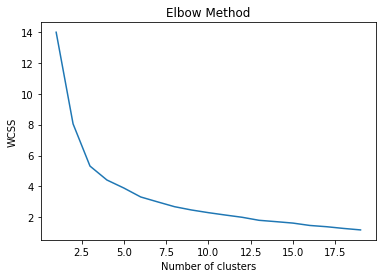

In [8]:
# Find optimal k for Kmeans using elbow method
wcss = []
N = 20

ohe = OneHotEncoder()

X = ohe.fit_transform(df[['tier_category', 'rating_category']])
_agg_cols = list(ohe.categories_[0])+list(ohe.categories_[1])

df_agg = pd.DataFrame.sparse.from_spmatrix(X, columns=_agg_cols)
_aux_cols = df_agg.columns.tolist()
_aux_cols[3] = 'Unknown Price'
df_agg.columns = _aux_cols
df_agg['barrio'] = df['barrio']
df_agg = df_agg.groupby('barrio').mean()


for i in range(1, N):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X=df_agg)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, N), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X=df_agg)
pd.DataFrame(kmeans.cluster_centers_, columns=_agg_cols).round(1)

,Cheap,Expensive,Moderate,Unknown price,Very Expensive,Average,Excelent,Good,Unknown rating
0,0.2,0.2,0.5,0.1,0.0,0.1,0.1,0.4,0.5
1,0.3,0.2,0.5,0.0,0.0,0.1,0.2,0.6,0.1
2,0.6,0.1,0.3,0.0,0.0,0.2,0.0,0.3,0.6
3,0.0,0.1,0.9,0.0,0.0,0.0,0.0,0.1,0.9
4,0.4,0.1,0.4,0.0,0.0,0.2,0.1,0.5,0.2
5,0.4,0.1,0.4,0.0,0.0,0.0,0.0,0.2,0.8


In [25]:
# See how the data for each cluster is distributed
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X=df_agg)
_clusters = kmeans.predict(df_agg.iloc[:,:9])
with open('cluster_output.txt', 'w') as _f:
    for _ in range(max(_clusters)+1):
        print('Neighborhoods belonging to cluster', _, file=_f)
        print(df_agg[_clusters==_], file=_f, end='\n\n')